In [6]:
import sys
import healpy as hp
from astropy import units
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


sys.path.append('/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter')

import maps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nside = 128
resolution = (hp.nside2resol(nside) * units.rad).to(units.deg).value

# Input map

In [3]:
seed = 747

Text(0, 0.5, 'dec')

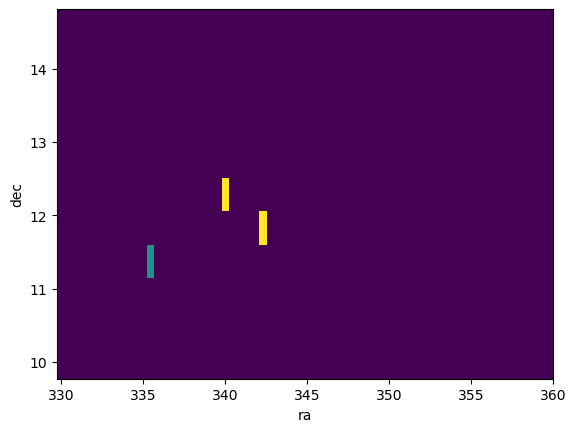

In [4]:
input_map = maps.InputMap(ra_max=360, ra_min=330, 
                          dec_max=15, dec_min=10,
                          nsources=3, 
                          resolution=resolution,
                          seed=seed)

map2d = input_map.get_2d_map(brightness=[1,1,0.5])

plt.pcolor(input_map.ra, input_map.dec, map2d)
plt.xlabel('ra')
plt.ylabel('dec')

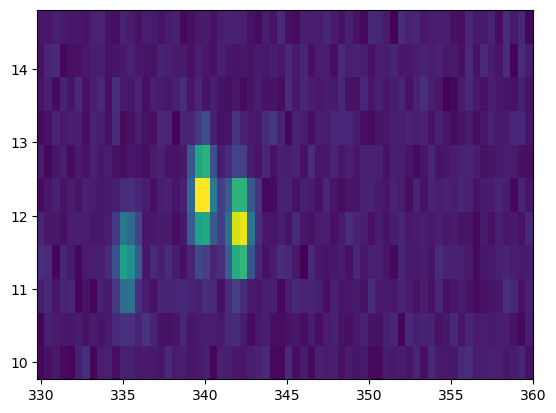

In [5]:
beam2d = input_map.get_2d_beam(maps.gaussian_beam, 1)

map_obs = input_map.observe(map2d, beam2d, add_noise=True, noise_std=3e-2)

plt.pcolor(input_map.ra, input_map.dec, map_obs)
plt.show()

# Adding a taper to the 2D map

In [17]:
import skimage
win = skimage.filters.window('tukey', map_obs.shape)

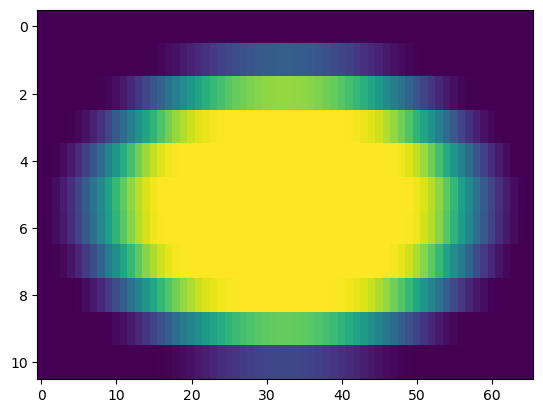

In [18]:
plt.imshow(win, aspect='auto')

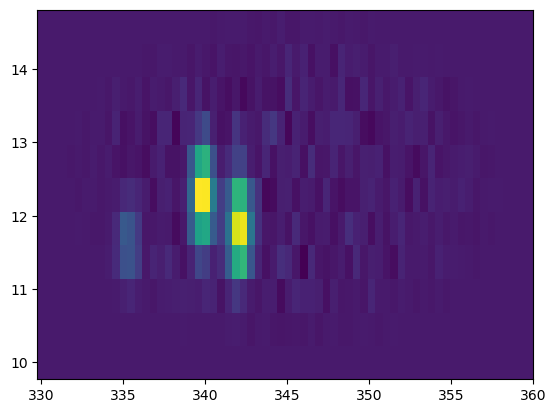

In [20]:
map2d_taper = map_obs * win
plt.pcolor(input_map.ra, input_map.dec, map2d_taper)
plt.show()

# turn 1d

In [25]:
map1d = input_map.get_1d_map(nside=nside, map_2d=map2d_taper)
beam1d = input_map.get_1d_map(nside, beam2d)

# matched filters

In [23]:
denom = np.fft.fft2(np.sqrt(beam2d * beam2d))

mf2d_denom = np.fft.fftshift(
    np.fft.ifftshift(
    np.fft.ifft2(
        np.fft.fftshift(
            np.fft.fft2(map2d_taper) * np.fft.fft2(beam2d) / denom
    ))))


In [26]:
denom = np.fft.fft(np.sqrt(beam1d * beam1d))

mf1d_denom = np.fft.fftshift(
    np.fft.ifftshift(
    np.fft.ifft(
        np.fft.fftshift(
            np.fft.fft(map1d) * np.fft.fft(beam1d) / denom
    ))))

# comparing 1d and 2d

In [27]:
mf_1d_to_2d = input_map.get_2d_from_1d(mf1d_denom.real)

to_1d = input_map.get_1d_map(nside, mf2d_denom)
mf_2d_to_2d = input_map.get_2d_from_1d(to_1d)

/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter/maps.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  map_1d[pix] += map_2d[j, i]


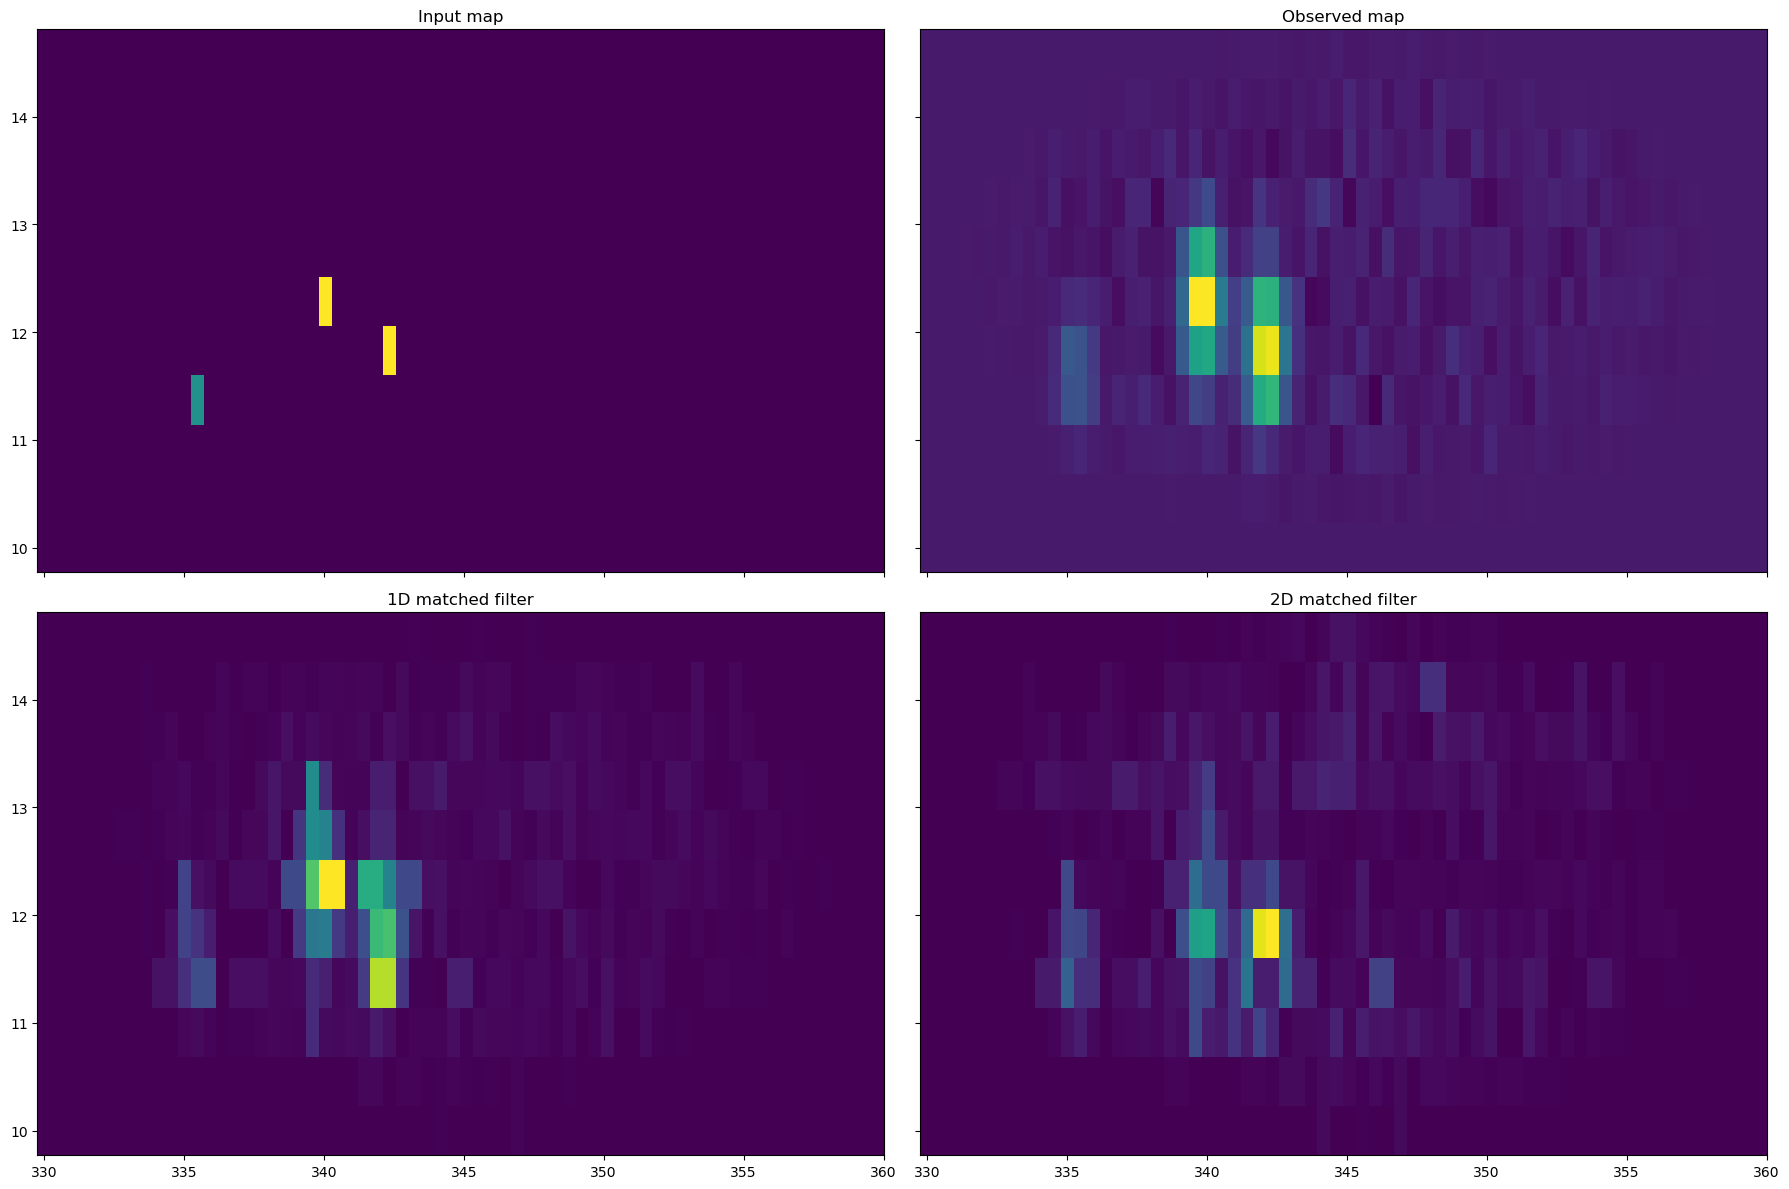

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(18,12))

ax[0,0].pcolor(input_map.ra, input_map.dec, map2d)
ax[0,0].set_title('Input map')

ax[0,1].pcolor(input_map.ra, input_map.dec, map2d_taper)
ax[0,1].set_title('Observed map')

ax[1,0].pcolor(input_map.ra, input_map.dec, np.abs(mf_1d_to_2d))
ax[1,0].set_title('1D matched filter')

ax[1,1].pcolor(input_map.ra, input_map.dec, np.abs(mf_2d_to_2d))
ax[1,1].set_title('2D matched filter')

plt.tight_layout()
plt.show()